#### Import modules

In [6]:
# !pip install -r requirements_netflix_jung.txt
# !pip install -r requirements_netflix_jung_lite.txt

# !pip list

# !pip install ktrain
!pip install pandas==1.3.0

     |████████████████████████████████| 10.8 MB 5.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.0 which is incompatible.


In [1]:
# !pip install adjustText
# !pip install bert-embedding
# !pip install umap-learn

In [3]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import string
import os
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D 
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models
from gensim.test.utils import datapath
from gensim.test.utils import common_texts, get_tmpfile

# spacy for lemmatization
import spacy

import os.path
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text
from sklearn.manifold import TSNE
from transformers import BertTokenizer, TFBertModel
# from bert_embedding import BertEmbedding
# import matplotlib.cm as cm
# import seaborn as sns
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS
# from adjustText import adjust_text
# import umap
# import umap.umap_ as umap
# # import umap.plot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Import the dominant topics based on the chosen model

In [4]:
mallet_lda_df = pd.read_pickle('lda_mallet_model/mallet_lda_df.pkl')
df = pd.read_pickle('raw_data/all_reviews_p3.pkl')
df = pd.concat([mallet_lda_df.reset_index(drop=True), df.loc[:, ['rating', 'review']].reset_index(drop=True)], axis = 1)

#### Check the topic labels(which are to be the target variables)

In [5]:
topic_dict = {0.: "Trouble-shooting", 1.: "User-Experience", 2.: "Cost-Value", 3.: "Time", 4.: "Service", 5.:"Others"}

In [6]:
representative_topics = df.groupby('Dominant_Topic').max().loc[:, "Perc_Contribution"]
pairs = list(zip(representative_topics.index, representative_topics.values))
representative_topics = df.loc[df.apply(lambda x: (x.Dominant_Topic, x.Perc_Contribution) in pairs, axis = 1),:].sort_values('Dominant_Topic')
representative_topics.loc[:, 'Dominant_Topic'] = ['0. Trouble-shooting', '1. User-Experience', '2. Cost-Value', '3. Time', '4. Service', '5. Others']
representative_topics.loc[:, 'review'] = representative_topics.loc[:, 'review'].map(lambda x: x[:500])

In [7]:
representative_topics.style.set_properties(subset=['review'], **{'width': '400px'})

,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
25138,0. Trouble-shooting,0.928000,"app, location, ride, option, update, time, work, issue, phone, number","['hogging', 'app', 'app', 'access', 'sms', 'permission', 'app', 'function', 'attempt', 'information', 'message', 'ban', 'app', 'data', 'violation', 'uninstalling_app']",1,Frustrated by such data hogging apps. My Personal Data is compromised by this app as it makes granting access to my sms mandatory. This permission is not atall essential for the app function and is a clear attempt to extract personal and financial information from my messages. App store should ban this app till such data violations are plugged. Uninstalling the app immediately.
28774,1. User-Experience,0.936800,"driver, car, service, passenger, time, app, customer, rider, trip, route","['convenient', 'driver', 'passenger', 'passenger', 'driver', 'time', 'situation', 'driver', 'trip', 'traffic', 'area', 'customer', 'rating', 'system', 'driver', 'rating', 'customer', 'rating', 'rating']",3,"The app is easy to use and convenient. However, it favours drivers over passengers. For example, if a passenger cancels a trip, he/she will be charged £5 in London. But drivers pick up and cancel trips all the time. Several times, I’ve been in a situation, when 3 or 4 drivers in a row picked up my trip, I waited for 7-10 minutes for each of them, and then they cancelled (I ended up being late). There was no bad traffic in the area. For me as a customer, it feels really unfair. Also, the ratings"
25573,2. Cost-Value,0.968400,"driver, app, ride, trip, service, money, charge, amount, card, payment","['day', 'ola', 'account', 'care', 'information', 'team', 'last_month', 'time', 'grievance', 'team', 'support', 'email', 'response', 'mail', 'payment', 'charge', 'month', 'email', 'agent', 'pay', 'charge', 'account', 'mail', 'last_day', 'action', 'mail', 'grievance', 'support', 'team', 'clear_due', 'clear_due', 'response', 'contact', 'phone', 'time', 'call', 'channel', 'phone', 'customer_service']",1,"One sudden day, my ola account got blocked for permanently. When contacted the customer care, they said they had no information about my account getting blocked and asked me to drop mail to the ola grievance team, ever since the last 2 months, I have mailed multiple time s to the grievance team and other ola support emails, but got no valid response although have kept on receiving multiple mails and calls, for the payment of due ola money charges throughout last two months, I have confirmed them"
9997,3. Time,0.930600,"driver, time, taxi, app, car, price, minute, service, work, trip","['euro', 'taxi', 'taximeter', 'fare', 'charge', 'taxi', 'fare', 'mean', 'trip', 'work', 'home', 'cost', 'taximeter', 'taxi', 'taxi', 'pricing', 'taximeter', 'taxi']",3,"The prices vary multiple euros (more expensive) if the taxi is using a taximeter or using the app for the fare pricing. The app calculates a higher fare charge if you take same taxi fare pricing, but with different means of measurments. The trip from work to home costs around 7-8 euros with a taximeter taxi, but the private or the a taxi what uses the app, its 10-11 euros, even though the pricing is sometimes even cheaper than the taximeter taxi."
18255,4. Service,0.905700,"service, love, ride, driver, app, price, time, travel, experience, discount","['share_car', 'travel', 'use', 'fuel', 'driving', 'effort', 'company', 'chat', 'app', 'thousand', 'tonne', 'carbon', 'emission']",5,"A great way to share car travel, while you make best use of fuel and the driving efforts, get a good company to chat along. This App is helping save thousands of tonnes of carbon emissions."
23367,5. Others,0.937200,"driver, ride, time, service, cab, location, app, auto, trip, customer","['train', 'ride', 'gandhinagar', 'ahmedabad', 'railway_station', 'ride', 'detail', 'min', 'pickup', 'time', 'without_intimation', 'unavailability', 'cab', 'area', 'time', 'app', 'book', 'cab', 'time']",1,"I almost

#### Start Modeling BERT
#### Code from [ktrain](https://github.com/amaiya/ktrain/)
Using the topic labels as the target label, use BERT to classify the unseen data, and compare the results with the LDA model's prediction on the unseen data to see which model classified the unseen review better.
<br><br>
[Hugging Face](https://github.com/huggingface/transformers) may be a common package to use.

#### In the training set, exclude examples that have 1/6 chance in the dominant topic. Because that means the dominant topic is just as likely as the other five topics.

In [8]:
mask = df.Perc_Contribution > 0.1667
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df.loc[mask, ['review', 'Dominant_Topic']],
                                                                   text_column = 'review',
                                                                   label_columns = 'Dominant_Topic',
                                                                   maxlen=512,
                                                                   preprocess_mode='bert')

/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')
/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


['Dominant_Topic_0.0', 'Dominant_Topic_1.0', 'Dominant_Topic_2.0', 'Dominant_Topic_3.0', 'Dominant_Topic_4.0', 'Dominant_Topic_5.0']
       Dominant_Topic_0.0  ...  Dominant_Topic_5.0
27493                 0.0  ...                 0.0
14505                 0.0  ...                 0.0
11202                 0.0  ...                 0.0
12805                 0.0  ...                 0.0
28630                 0.0  ...                 0.0

[5 rows x 6 columns]
['Dominant_Topic_0.0', 'Dominant_Topic_1.0', 'Dominant_Topic_2.0', 'Dominant_Topic_3.0', 'Dominant_Topic_4.0', 'Dominant_Topic_5.0']
       Dominant_Topic_0.0  ...  Dominant_Topic_5.0
16460                 1.0  ...                 0.0
26535                 1.0  ...                 0.0
22078                 0.0  ...                 0.0
7783                  0.0  ...                 1.0
10926                 0.0  ...                 1.0

[5 rows x 6 columns]
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████

Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
# %%time
# model = text.text_classifier(name='bert',
#                              train_data=(x_train, y_train),
#                              preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.
CPU times: user 5.59 s, sys: 803 ms, total: 6.39 s
Wall time: 10.9 s


In [ ]:
# %%time
# learner = ktrain.get_learner(model=model,
#                              train_data=(x_train, y_train),
#                              val_data=(x_test, y_test),
#                              batch_size=1)

CPU times: user 437 ms, sys: 456 ms, total: 893 ms
Wall time: 1.38 s


In [ ]:
%%time
learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
23835/23835 [==============================] - 8504s 356ms/step - loss: 1.1875 - accuracy: 0.5588 - val_loss: 0.8960 - val_accuracy: 0.6795
CPU times: user 3h 8min 37s, sys: 12min 2s, total: 3h 20min 39s
Wall time: 2h 22min 37s


In [ ]:
%%time
# # reload Predictor and extract model
model = ktrain.load_predictor('/content/gdrive/MyDrive/bert_model_all').model

# # re-instantiate Learner and continue training
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=1)
# learner.fit_onecycle(2e-5, 1)

CPU times: user 6.85 s, sys: 2.47 s, total: 9.32 s
Wall time: 51.1 s


In [ ]:
%%time
# 2nd training, 26.07.2021 03:00 AM
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
23363/23835 [============================>.] - ETA: 2:52 - loss: 0.8717 - accuracy: 0.6887

In [ ]:
%%time
# save model and Preprocessor instance after partially training
# ktrain.get_predictor(model, preproc).save('bert_model')
# ktrain.get_predictor(model, preproc).save('bert_model_all')
ktrain.get_predictor(model, preproc).save('bert_model_all_p2')

In [17]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [20]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  
  file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
      }
  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                media_body=media,
                                fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


In [ ]:
# save_file_to_drive('/', '/content/bert_model_all/tf_model.h5')
# save_file_to_drive('bert_model_all/', '/content/bert_model_all/tf_model.h5')
# save_file_to_drive('bert_model_all/', '/content/bert_model_all/tf_model.preproc')
save_file_to_drive('bert_model_all_p2.h5', '/content/bert_model_all_p2/tf_model.h5')
save_file_to_drive('bert_model_all_p2.preproc', '/content/bert_model_all_p2/tf_model.preproc')

File ID: 1Qbb8ct6CZtRy7rpb583EWcV5QxDdBGdN
File ID: 1E5dXpvpOKQ6fZE31x_-WaWeGW3Pc1kug


{'id': '1E5dXpvpOKQ6fZE31x_-WaWeGW3Pc1kug'}

In [ ]:
%%time
# 3rd training, 26.07.2021 ETA 05:00 AM bert_model_all_p3
learner.fit_onecycle(2e-5, 1)

In [ ]:
%%time
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('bert_model_all_p3')

save_file_to_drive('bert_model_all_p3.h5', '/content/bert_model_all_p3/tf_model.h5')
save_file_to_drive('bert_model_all_p3.preproc', '/content/bert_model_all_p3/tf_model.preproc')

In [ ]:
# save_file_to_drive('bert_model_all_p3.h5', '/content/bert_model_all_p3/tf_model.h5')
# save_file_to_drive('bert_model_all_p3.preproc', '/content/bert_model_all_p3/tf_model.preproc')

In [ ]:
# %%time
# # # reload Predictor and extract model
# model = ktrain.load_predictor('bert_model_v0271').model

# # # re-instantiate Learner and continue training
# # learner = ktrain.get_learner(model=model,
# #                              train_data=(x_train, y_train),
# #                              val_data=(x_test, y_test),
# #                              batch_size=1)
# # learner.fit_onecycle(2e-5, 1)

CPU times: user 7.95 s, sys: 1.13 s, total: 9.08 s
Wall time: 8.7 s


In [ ]:
# %%time
# # save model and Preprocessor instance after partially training
# ktrain.get_predictor(model, preproc).save('bert_model_v0271_part2')

### Predicting Topic with unseen text(validation set)

In [ ]:
# pip install pickle5

In [ ]:
import pickle5 as pickle
with open('prediction/LDA_preds.pkl', "rb") as fh:
  LDA_preds = pickle.load(fh)

# LDA_preds

In [ ]:
# BERT_preds, BERT_proba = pd.read_pickle('prediction/BERT_preds.pkl'), pd.read_pickle('prediction/BERT_proba.pkl')
# LDA_preds, LDA_proba = pd.read_pickle('prediction/LDA_preds.pkl'), pd.read_pickle('prediction/LDA_proba.pkl')
# LDA_preds = pd.read_pickle('prediction/LDA_preds.pkl')

In [ ]:
# BERT_preds
# BERT_proba
# LDA_preds
# LDA_proba

In [ ]:
# Import hold_out validation dataset
# df = pd.read_pickle('raw_data/netflix_val.pkl')
df_val = pd.read_csv('raw_data/all_reviews_p2.csv', index_col=0)
df_val = df_val.reset_index(drop=True)
df_val = df_val.head(6000)
reviews = df_val.review.values.tolist()
# reviews

In [ ]:
# df_val.to_pickle('raw_data/all_reviews_p2_6000_val.pkl')

In [12]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [13]:
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [14]:
# reload Predictor and extract model
# model = ktrain.load_predictor('bert_model').model
model = ktrain.load_predictor('/content/gdrive/MyDrive/bert_model_all_p3').model


# # re-instantiate Learner
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=1)

In [19]:
%%time
# 4th training, 26.07.2021 ETA 05:00 AM bert_model_all_p3
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
23835/23835 [==============================] - 10467s 439ms/step - loss: 0.4546 - accuracy: 0.8492 - val_loss: 0.3935 - val_accuracy: 0.8735
CPU times: user 3h 11min 46s, sys: 21min 7s, total: 3h 32min 53s
Wall time: 2h 55min 22s


In [21]:
%%time
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('bert_model_all_p4')

save_file_to_drive('bert_model_all_p4.h5', '/content/bert_model_all_p4/tf_model.h5')
save_file_to_drive('bert_model_all_p4.preproc', '/content/bert_model_all_p4/tf_model.preproc')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


File ID: 18_bNc_Br5JwXQLG6C42S4stUuUK_Tm9_
File ID: 1rRNVgeNfeyJdEAZw0zTgIrwmmCJ0OFjF
CPU times: user 3.28 s, sys: 2.09 s, total: 5.37 s
Wall time: 23.9 s


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
%time predicted_topics = predictor.predict(reviews)

CPU times: user 39.1 s, sys: 4.87 s, total: 44 s
Wall time: 4min 26s


In [ ]:
BERT_preds = [float(topic.replace('Dominant_Topic_', '')) for topic in predicted_topics]

In [ ]:
%time BERT_proba = predictor.predict_proba(reviews)

CPU times: user 35.4 s, sys: 4.8 s, total: 40.2 s
Wall time: 5min 24s


In [ ]:
# predictor = ktrain.get_predictor(learner.model, preproc)

# %time predicted_topics = predictor.predict(reviews)
# BERT_preds = [float(topic) for topic in predicted_topics]

# %time BERT_proba = predictor.predict_proba(reviews)

In [ ]:
LDA_preds = LDA_preds[:6000]

In [ ]:
# len(BERT_preds)
# len(LDA_preds)

6000

In [ ]:
# BERT_proba

In [ ]:
pd.to_pickle(BERT_preds, 'prediction/BERT_preds.pkl')
pd.to_pickle(BERT_proba, 'prediction/BERT_proba.pkl')

#### Compare with LDA model

Only 21.66% of the predicted labels are the same..

In [ ]:
# mask = LDA_preds == np.array(BERT_preds)
# sum(mask) / len(BERT_preds)

0.4322775744071303

In [ ]:
np.array(LDA_preds)

array([2., 1., 2., ..., 2., 2., 4.])

In [ ]:
np.array(BERT_preds)

array([2., 1., 2., ..., 1., 4., 0.])

In [ ]:
# mask = LDA_preds == np.array(BERT_preds)
mask = np.array(LDA_preds) == np.array(BERT_preds)
sum(mask) / len(BERT_preds)

0.21666666666666667

### Predicting Topic with ad-hoc text

In [ ]:
# new_text = "I think I really like the app. Thanks for making this useful app."
new_text = "Loving the app, but can only give it a medium rating at the moment as the drivers you give a bad rating on still gets your trip. I had a bad experience with a driver outside my apartment, but he always gets my rides as he's parked there when with my one star and bad review (refused to drive to the destination, rude and aggressive)."

In [ ]:
# model = ktrain.load_predictor('bert_model').model
# preproc = ktrain.load_predictor('bert_model').preproc
# predictor = ktrain.get_predictor(model, preproc)

In [ ]:
predictor.predict(new_text, return_proba=True)

array([0.05290329, 0.75876015, 0.01160376, 0.05958213, 0.01841391,
       0.09873671], dtype=float32)

In [ ]:
percentages = predictor.predict(new_text, return_proba=True)
topics = ["Trouble-shooting", "User-Experience", "Cost-Value", "Time", "Service", "Others"]
indices = np.argsort(percentages)[::-1]
[topics[index] for index in indices]

['User-Experience',
 'Others',
 'Time',
 'Trouble-shooting',
 'Service',
 'Cost-Value']

In [ ]:
[100*np.round(percentages[index], 3) for index in indices]

[75.90000033378601,
 9.89999994635582,
 5.999999865889549,
 5.299999937415123,
 1.7999999225139618,
 1.2000000104308128]

### Plotting the word embeddings

There's 9149 documents with 512 dimensions for embedding in training set and 6283 documents with 512 dimensions for embedding in validation set.

### TSNE
According to the [source code](https://github.com/amaiya/ktrain/blob/master/ktrain/text/preprocessor.py), BERTPreprocessor's preprocess function returns (preprocessed x, preprocessed y)

In [ ]:
preproc_val = preproc.preprocess(reviews)
preprocessed_X = preproc_val[0]
tsne = TSNE(n_components=3, random_state = 0)

In [ ]:
%time tsne_3d_coordinates = tsne.fit_transform(preprocessed_X)

CPU times: user 7min 56s, sys: 685 ms, total: 7min 57s
Wall time: 4min 18s


#### Representative embeddings with 99.5% probability

In [ ]:
print(BERT_proba.argmax(axis=0))
print(BERT_proba.max(axis=0).round(5))
# ["Trouble-shooting", "User-Experience", "Cost-Value", "Time", "Service", "Others"]

[3436 1998 1742 3032  475 2268]
[0.94768 0.98635 0.94452 0.93476 0.98977 0.93264]


In [ ]:
df_reset_index = df.reset_index(drop=True)
representative_reviews = df_reset_index.iloc[BERT_proba.argmax(axis=0), :]['review'].values

### BERT visualization

In [ ]:
total_indices = np.array(range(len(BERT_proba)))
major_docs = total_indices[BERT_proba.max(axis=1) >= 0.99]
x_coords, y_coords, z_coords = tsne_3d_coordinates[major_docs,0], tsne_3d_coordinates[major_docs,1], tsne_3d_coordinates[major_docs, 2]
len(major_docs)

0

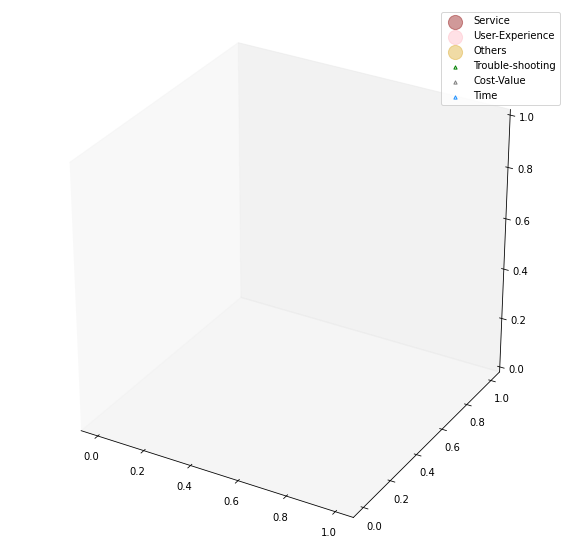

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in [4, 1, 5]:
    mask = np.array(BERT_preds)[major_docs] == label
    ax.scatter3D(x_coords[mask], y_coords[mask], z_coords[mask], c=colors[label], label=topic_dict[label], alpha=.4, marker = 'o', s=200)

# for label in [0, 2, 3]:
#     mask = np.array(BERT_preds)[major_docs] == label
#     ax.scatter3D(x_coords[mask], y_coords[mask], z_coords[mask], facecolor=(1,1,1,0), edgecolor=colors[label],alpha=1, label=topic_dict[label], marker = '^', s=10)

ax.grid(False)
ax.legend();
# plt.savefig('images/{}'.format("bert_tsne"), dpi=200, transparent=True, bbox_inches = "tight");

In [ ]:
print(matplotlib.colors.to_rgba("green"), matplotlib.colors.cnames["lightpink"], matplotlib.colors.cnames["gray"],
      matplotlib.colors.cnames["dodgerblue"], matplotlib.colors.cnames["darkred"], matplotlib.colors.cnames["goldenrod"])

(0.0, 0.5019607843137255, 0.0, 1.0) #FFB6C1 #808080 #1E90FF #8B0000 #DAA520


### Wordcloud

In [ ]:
reviews_df = pd.concat([pd.Series(reviews), pd.Series(BERT_preds)], axis = 1)
reviews_df.columns = ['review', 'pred']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

tokenized_text = []
for review in reviews_df.loc[:,'review']:
    tokenized_text.append(tokenizer.tokenize(review))

In [ ]:
def one_string(texts, boolean_mask):
    thing = ' '.join([' '.join(item) for item in [row for row, boolean in zip(texts, boolean_mask) if boolean]])
    thing = re.sub(r'[ ]{2,}', ' ', thing)
    return re.sub(r'#', '', thing)

def create_wordcloud(img_directory, id, contour_width=3, contour_color='green', background_color="white"):
    topic_ids = np.array(reviews_df.pred)
    mask = np.array(Image.open(img_directory))
    stop_words = set(stopwords.words('english')) | {'<','>',"'",'-','/',',','!','.','br','&',';','?',')','#','##s','##ing','le','ha','wa',
                                                'would','great','watch','stars','bolt','taxify','uber','blablacar'}
    # Removed words that appeared in all or most topics
    wc = WordCloud(background_color=background_color, max_words=15, mask=mask, stopwords=stop_words,
                   max_font_size=100, random_state=40, contour_width=contour_width, contour_color=contour_color)
    wc.generate(one_string(tokenized_text, topic_ids == id))
    return wc

In [ ]:
# plt.figure(figsize=(10,6))
# plt.title('Trouble-shooting(Video-related)', fontsize=20); plt.imshow(create_wordcloud('images/problem.png', 4,contour_color='darkred'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_trouble"), dpi=200, transparent=True, bbox_inches = "tight")
# plt.figure(figsize=(10,6))
# plt.title('User Experience', fontsize=20); plt.imshow(create_wordcloud('images/family.png', 1,contour_color='lightpink'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_user"), dpi=200, transparent=True, bbox_inches = "tight")
# plt.figure(figsize=(10,6))
# plt.title('Shows', fontsize=20); plt.imshow(create_wordcloud('images/show.png', 5,contour_color='goldenrod'), interpolation='spline36'); plt.axis("off");
# plt.savefig('images/{}'.format("bert_shows"), dpi=200, transparent=True, bbox_inches = "tight")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

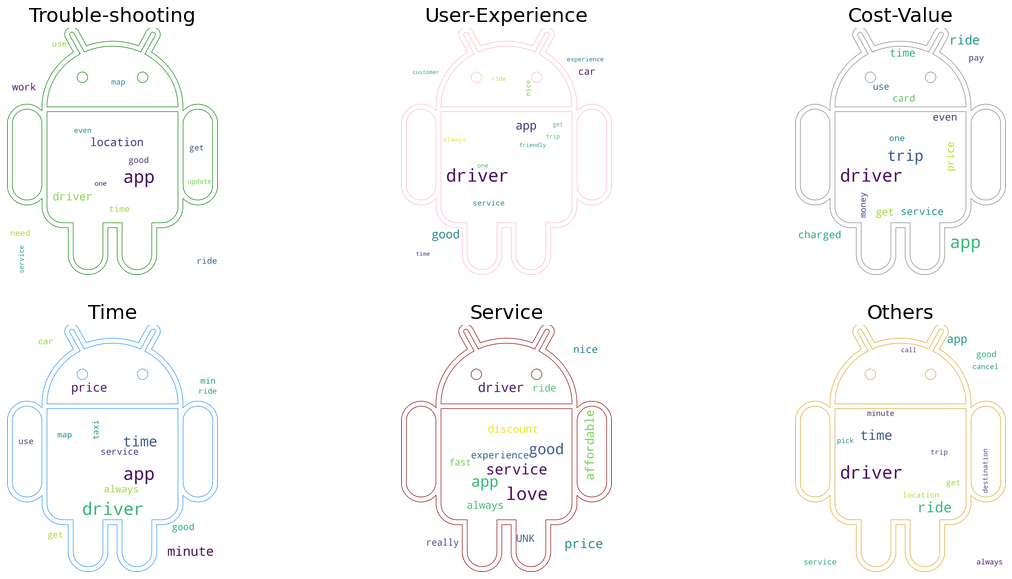

In [ ]:
# ["Trouble-shooting", "User-Experience", "Cost-Value", "Time", "Service", "Others"]
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
ax[0,0].set_title('Trouble-shooting', fontsize=20); ax[0,0].imshow(create_wordcloud('images/android.png', 0), interpolation='spline36'); ax[0,0].axis("off")
ax[0,1].set_title('User-Experience', fontsize=20); ax[0,1].imshow(create_wordcloud('images/family.png', 1,contour_color='lightpink'), interpolation='spline36'); ax[0,1].axis("off")
ax[0,2].set_title('Cost-Value', fontsize=20); ax[0,2].imshow(create_wordcloud('images/think.png', 2,contour_color='gray'), interpolation='spline36'); ax[0,2].axis("off")
ax[1,0].set_title('Time', fontsize=20); ax[1,0].imshow(create_wordcloud('images/service.png', 3,contour_color='dodgerblue'), interpolation='spline36'); ax[1,0].axis("off")
ax[1,1].set_title('Service', fontsize=20); ax[1,1].imshow(create_wordcloud('images/problem.png', 4,contour_color='darkred'), interpolation='spline36'); ax[1,1].axis("off")
ax[1,2].set_title('Others', fontsize=20); ax[1,2].imshow(create_wordcloud('images/show.png', 5,contour_color='goldenrod'), interpolation='spline36'); ax[1,2].axis("off");

plt.savefig('images/{}'.format("bert_wordcloud"), dpi=200, transparent=True, bbox_inches = "tight")

#### Keywords and frequencies stored in a list of dictionaries "frequencies_topics"

In [ ]:
UPPER = 10
stop_words = set(stopwords.words('english')) | {'<','>',"'",'-','/',',','!','.','br','&',';','?',')','#','##s','##ing','le','ha','wa',
                                                'would','great','watch','stars','bolt','taxify','uber','blablacar'}
# Removed words that appeared in all or most topics

frequencies_topics = [0]*6
for topic_id in range(6):
    frequencies = defaultdict(int)
    for review in reviews_df.loc[reviews_df.pred == topic_id, 'review']:
        for word in tokenizer.tokenize(review):
            if word not in stop_words:
                frequencies[word] += 1
    keys = list(frequencies.keys())
    frequent_indices = np.argsort(list(frequencies.values()))[::-1][:UPPER]
    frequent_words = set(np.array(keys)[frequent_indices])
    frequencies_topics[topic_id] = frequent_words
    
    print(f"Topic: {topic_dict[topic_id]}")
    print(frequent_words,'\n')

Topic: Trouble-shooting
{'drivers', 'work', 'ride', 'use', 'driver', 'time', 'map', 'app', 'location', 'good'} 

Topic: User-Experience
{'service', 'drivers', 'car', 'nice', 'always', 'driver', 'app', 'friendly', 'good', 'cars'} 

Topic: Cost-Value
{'service', 'drivers', 'ride', 'card', 'driver', 'trip', 'use', 'app', 'even', 'customer'} 

Topic: Time
{'price', 'drivers', 'always', 'times', 'driver', 'use', 'time', 'app', 'minutes', 'good'} 

Topic: Service
{'service', 'drivers', 'affordable', 'love', 'always', 'use', 'app', 'easy', 'friendly', 'good'} 

Topic: Others
{'service', 'drivers', 'cancel', 'ride', 'driver', 'rides', 'time', 'app', 'location', 'good'} 



### TSNE 3d plot

In [ ]:
# # !pip uninstall umap
# !pip uninstall umap-learn
!pip install umap-learn

In [ ]:
import umap

In [ ]:
%time mapper3d = umap.UMAP(n_components=3, n_neighbors=7, random_state=0).fit(preprocessed_X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 34.8 s, sys: 441 ms, total: 35.3 s
Wall time: 34.7 s


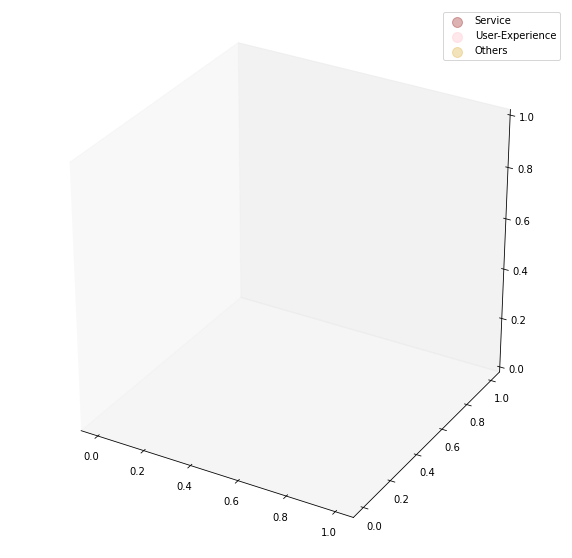

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
coords = mapper3d.embedding_
x,y,z = coords[major_docs,0], coords[major_docs,1], coords[major_docs,2]
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in [4, 1, 5]:
    mask = np.array(BERT_preds)[major_docs] == label
    ax.scatter3D(x[mask],y[mask],z[mask], c=colors[label], label=topic_dict[label], alpha=.3, marker = 'o', s=100)

# for label in [0, 2, 3]:
#     mask = np.array(BERT_preds)[major_docs] == label
#     ax.scatter3D(x[mask], y[mask], z[mask], facecolor=(1,1,1,0), edgecolor=colors[label],alpha=.5, label=topic_dict[label], marker = '.', s=100)
ax.grid(False)
ax.legend();

### TSNE 2d plot

In [ ]:
%time mapper2d = umap.UMAP(n_components=2, n_neighbors=9, random_state=0).fit(preprocessed_X)

CPU times: user 15 s, sys: 319 ms, total: 15.4 s
Wall time: 14.8 s


In [ ]:
coords = mapper2d.embedding_
x,y = coords[major_docs,0], coords[major_docs,1]

In [ ]:
topics_to_plot = [1,4,5]
indices = np.arange(len(preprocessed_X))[np.array([True if label in topics_to_plot else False for label in BERT_preds])]
major_docs_indices = list(set(major_docs).intersection(set(indices)))

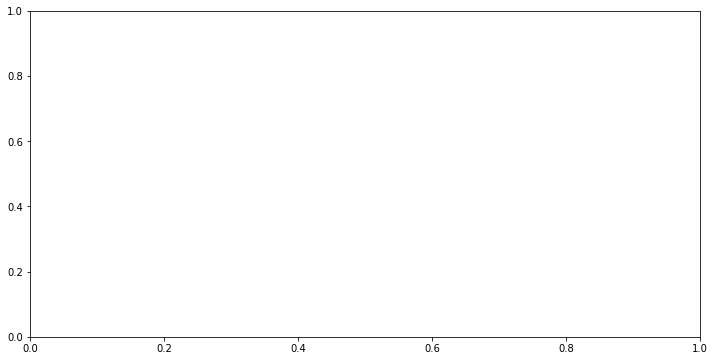

In [ ]:
coords = mapper2d.embedding_
# indices = predicted_proba.argmax(axis=0)
x_coords, y_coords = coords[major_docs_indices,0], coords[major_docs_indices,1]
plt.figure(figsize=(12, 6))
# plt.scatter(x_coords, y_coords, marker='.', alpha=0.8, c=np.array(predicted_topics)[major_docs], cmap='viridis', hue = )
# plt.legend();
sns.scatterplot(x=x_coords, y=y_coords, hue=[topic_dict[topic_id] for topic_id in np.array(BERT_preds)[major_docs_indices]], alpha=0.6, s=100, marker='o')
plt.show()
# for label, x, y in zip(['Platform/Device', 'User', 'Value', 'Service', 'Trouble-shooting', 'Shows'], x_coords, y_coords):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points');

### BERT word embeddings 2d visualization with UMAP

In [ ]:
# embeddings = pd.read_pickle('bert_model/embeddings.pkl')
bert_embedding = BertEmbedding()
%time embeddings = bert_embedding(reviews)

Vocab file is not found. Downloading.
CPU times: user 13min 10s, sys: 6.97 s, total: 13min 17s
Wall time: 13min 12s


In [ ]:
pd.to_pickle(embeddings, 'bert_model_all/embeddings.pkl')

In [ ]:
# embeddings
tokens, embeds = embeddings[representative_docs[0]][0], embeddings[representative_docs[0]][1]
# tokens
# embeds

In [ ]:
BERT = pd.concat([pd.Series(BERT_preds), pd.Series(BERT_proba.max(axis=1))],axis=1)
BERT.columns = ['label', 'proba']

representative_docs, representative_docs_umap, tokens_per_doc = [], [], []

token_stopwords = set(stopwords.words('english')) | {"'",'.', ",", "would", "goes", "2", '-', 'five', 'stars'}
tsne = TSNE(n_components=2, random_state = 0)

for i in range(6):
    BERT_ = BERT.loc[BERT.label==i,:]
    representative_docs.append(BERT_.index[np.argmax(BERT_.proba)])# Most representative documents per topic
    tokens, embeds = embeddings[representative_docs[i]][0], embeddings[representative_docs[i]][1]
    indices = [i for (i, token) in enumerate(np.array(tokens)) if token not in token_stopwords]# Remove the stopwords from each topic
    clean_tokens = [tokens[i] for i in indices]
    
    tokens_per_doc.append(clean_tokens)    
    try:# Try UMAP first, and if it throws an error, try TSNE
        mapper2d = umap.UMAP(n_components=2, n_neighbors=2, random_state=1).fit(np.array([embeds[i] for i in indices]))
        representative_docs_umap.append(mapper2d.embedding_)
    except:
        representative_docs_umap.append(tsne.fit_transform(np.array([embeds[i] for i in indices])))

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


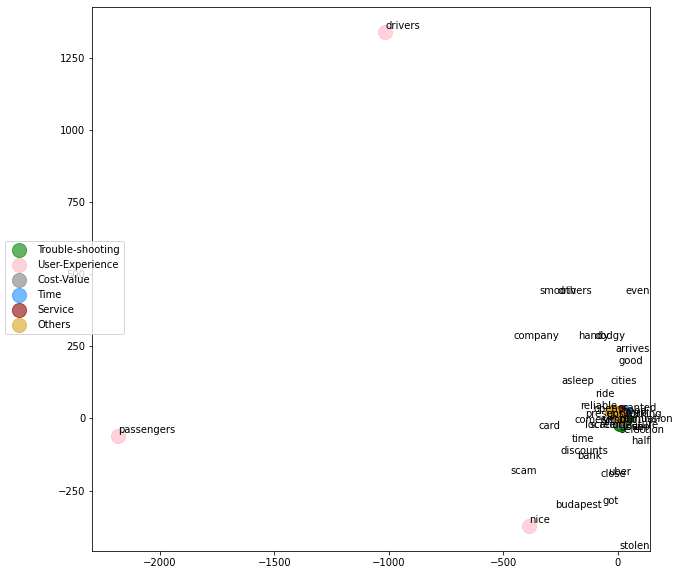

In [ ]:
ax = plt.figure(figsize=(10,10))
colors = ['green', 'lightpink', 'gray', 'dodgerblue', 'darkred', 'goldenrod']
for label in range(6):
    word_embeddings = representative_docs_umap[label]
    tokens = tokens_per_doc[label]
    x, y = word_embeddings[:, 0], word_embeddings[:, 1]
    plt.scatter(x, y, c=colors[label], label=topic_dict[label], alpha=0.6, marker = 'o', s=200);
    texts = [plt.text(x[i], y[i], tokens[i], ha='center', va='center') for i in range(len(x))]
    adjust_text(texts, avoid_points = False, expand_text = (1.05, 4.5))
ax.legend(loc=6)
ax.savefig('images/{}'.format("bert_cluster"), dpi=200, transparent=True, bbox_inches = "tight");